In [1]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import lime
from lime import submodular_pick
import lime.lime_tabular
from preprocessing import AdultPrep
import utils
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import re
import os
from scipy import stats
from copy import copy

# t-closeness
Here we only consider t-closeness

In [2]:
paths = sorted(
    [
        path
        for path in utils.get_absolute_file_paths("../data/anonymized_data/t-closeness")
        if not path.endswith(".txt")
    ]
)

paths.insert(0, os.path.abspath("../data/original.csv"))

In [3]:
data = []
file_names = []
for path in paths:
    file_name = path.split("/")[-1]
    file_names.append(file_name)
    if file_name == "original.csv":
        data.append(AdultPrep(pd.read_csv(path), is_anonymized=False))
    else:
        data.append(AdultPrep(pd.read_csv(path).iloc[:, 1:], is_anonymized=True))

Dropped 1221 rows


In [4]:
predictors = []
data_split = []
for file_name, adult_prep in zip(file_names, data):
    print(file_name)
    X_train, X_test, y_train, y_test = train_test_split(
        adult_prep.X, adult_prep.y, test_size=0.4, random_state=0
    )
    clf = MLPClassifier(
        solver="sgd", alpha=1e-5, hidden_layer_sizes=(10), random_state=1
    )
    clf.fit(adult_prep.one_hot_encoder.transform(np.array(X_train)), y_train)
    print(
        clf.score(
            adult_prep.one_hot_encoder.transform(np.array(X_test)), np.array(y_test)
        )
    )
    predictors.append(clf)
    data_split.append((X_train, X_test, y_train, y_test))

original.csv
0.8511732899364796
anon_data_t_0.1.csv
0.796130642812565
anon_data_t_0.2.csv
0.7965467027251925
anon_data_t_0.3.csv
0.8030996463490743
anon_data_t_0.4.csv
0.8030996463490743
anon_data_t_0.5.csv
0.8030996463490743
anon_data_t_0.6.csv
0.8051799459122113
anon_data_t_0.7.csv
0.8334720199708758
anon_data_t_0.8.csv
0.8488662367380903
anon_data_t_0.9.csv
0.8488662367380903


In [5]:
common_indices = utils.common_elements([df.index for (_, df, _, _) in data_split])

In [6]:
explainers = []
for adult_prep, clf, (X, _, _, _) in zip(data, predictors, data_split):
    explainer = lime.lime_tabular.LimeTabularExplainer(
        np.array(X),
        feature_names=adult_prep.feature_names,
        class_names=adult_prep.labels,
        categorical_features=adult_prep.categories_i(),
        categorical_names=adult_prep.encoder_mappings,
        kernel_width=3,
    )
    explainers.append(explainer)

In [7]:
explanations = []
for explainer, clf, adult_prep, (_, X, _, _) in zip(
    explainers, predictors, data, data_split
):
    np.random.seed(1)
    i = 21318  # common_indices[0]
    predict_fn = lambda x: clf.predict_proba(
        adult_prep.one_hot_encoder.transform(x)
    ).astype(float)
    exp = explainer.explain_instance(np.array(X.loc[i]), predict_fn, num_features=5)
    explanations.append(exp)

# Exploring differences between Data

## Plotting Differences

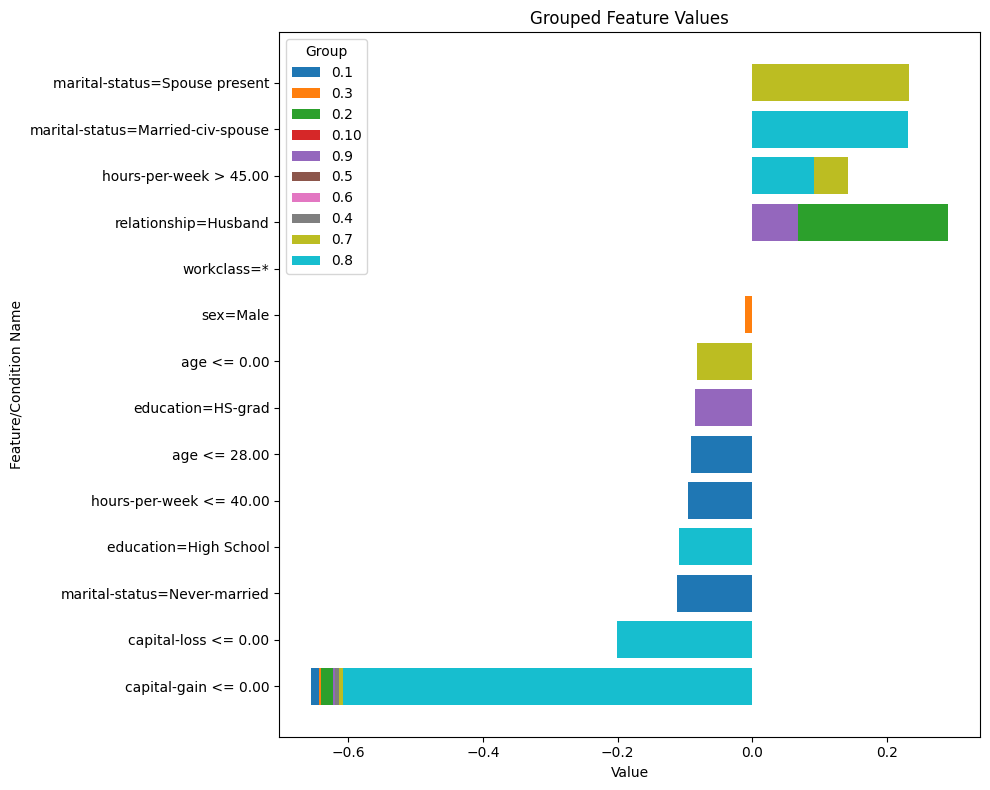

In [8]:
data_list = [exp.as_list() for exp in explanations]

combined_data = []
for i, group in enumerate(data_list):
    for name, value in group:
        combined_data.append({"Name": name, "Value": value, "Group": f"0.{i + 1}"})
df = pd.DataFrame(combined_data)

df = df.sort_values(by="Value", ascending=True)

plt.figure(figsize=(10, 8))

unique_names_sorted = df["Name"].unique().tolist()
y_pos = np.arange(len(unique_names_sorted))

for group_name in df["Group"].unique():
    group_df = df[df["Group"] == group_name]

    group_y_pos = [unique_names_sorted.index(name) for name in group_df["Name"]]

    plt.barh(group_y_pos, group_df["Value"], label=group_name)

plt.yticks(y_pos, unique_names_sorted)

plt.xlabel("Value")
plt.ylabel("Feature/Condition Name")
plt.title("Grouped Feature Values")
plt.legend(title="Group")
plt.tight_layout()
plt.savefig("grouped_feature_values_plot.png")

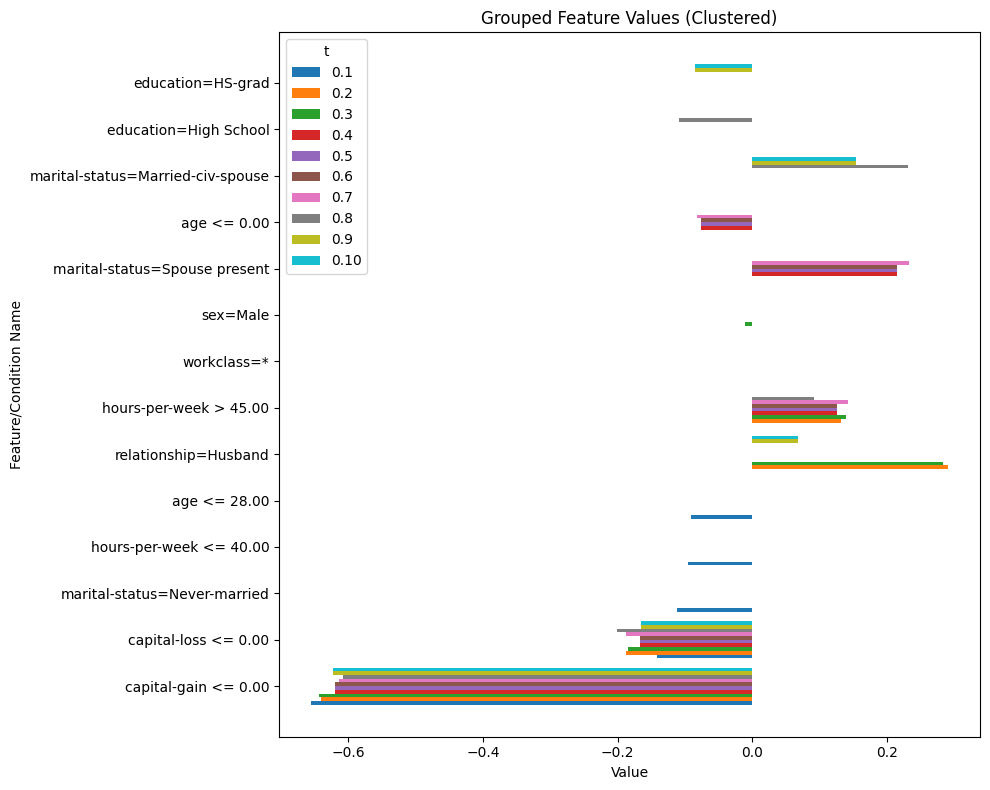

In [9]:
data_list = [exp.as_list() for exp in explanations]

combined_data = []
for i, exp in enumerate(data_list):
    for name, value in exp:
        combined_data.append({"Name": name, "Value": value, "t": f"0.{i + 1}"})
df = pd.DataFrame(combined_data)

plt.figure(figsize=(10, 8))

unique_names_sorted = df["Name"].unique().tolist()
y_pos = np.arange(len(unique_names_sorted))
groups = df["t"].unique()
N = len(groups)
bar_height = 0.8 / N

for k, group_name in enumerate(groups):
    group_df = df[df["t"] == group_name]

    offset = (k - (N - 1) / 2) * bar_height

    base_y_pos = [y_pos[unique_names_sorted.index(name)] for name in group_df["Name"]]

    group_y_pos_shifted = np.array(base_y_pos) + offset

    plt.barh(
        group_y_pos_shifted, group_df["Value"], height=bar_height, label=group_name
    )

plt.yticks(y_pos, unique_names_sorted)

plt.xlabel("Value")
plt.ylabel("Feature/Condition Name")
plt.title("Grouped Feature Values (Clustered)")
plt.legend(title="t")
plt.tight_layout()
plt.savefig("grouped_feature_values_clustered_plot.png")

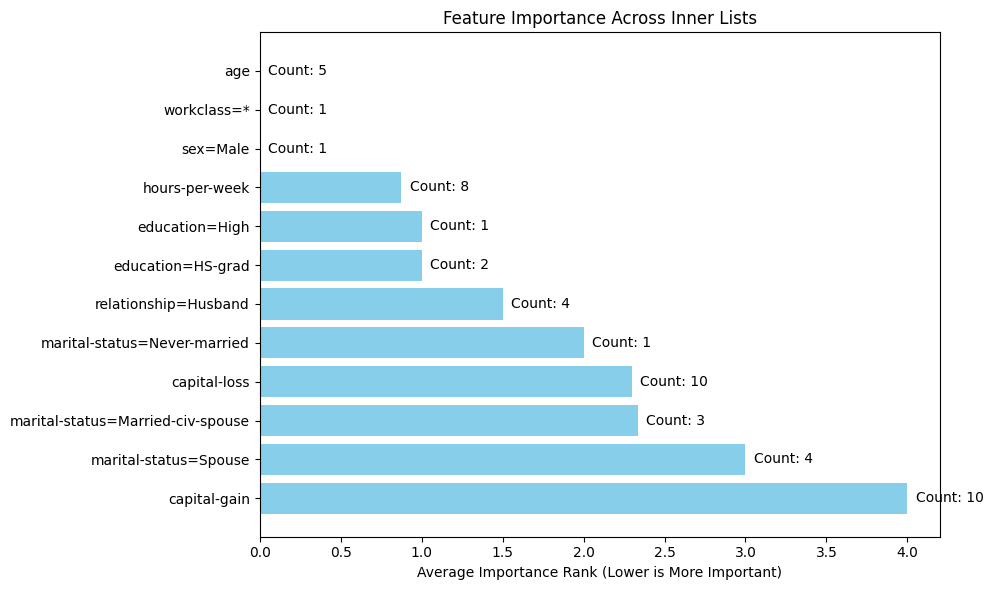

In [10]:
flat_data = []
for inner_list in [[name.split(" ")[0] for name, _ in l] for l in data_list]:
    for rank, feature in enumerate(reversed(inner_list)):
        flat_data.append({"Feature": feature, "Rank": rank})

df = pd.DataFrame(flat_data)
importance_df = (
    df.groupby("Feature")
    .agg(Avg_Rank=("Rank", "mean"), Count=("Rank", "count"))
    .reset_index()
)

importance_df = importance_df.sort_values(by="Avg_Rank", ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(importance_df["Feature"], importance_df["Avg_Rank"], color="skyblue")

ax.set_xlabel("Average Importance Rank (Lower is More Important)")
ax.set_title("Feature Importance Across Inner Lists")
ax.set_yticks(importance_df["Feature"])
ax.invert_yaxis()

for i, (count, rank) in enumerate(
    zip(importance_df["Count"], importance_df["Avg_Rank"])
):
    ax.text(rank + 0.05, i, f"Count: {count}", va="center")

plt.tight_layout()
plt.savefig("feature_importance_plot.png")

## Feature importance using submodular pick and Kendall's rank correlation

In [31]:
submodular_objects = []
for explainer, clf, adult_prep, (X, _, _, _), i in zip(
    explainers, predictors, data, data_split, file_names
):
    print(f"-------- Considering {i} --------")
    i = common_indices[0]

    predict_fn = lambda x: clf.predict_proba(
        adult_prep.one_hot_encoder.transform(x)
    ).astype(float)

    submodular_objects.append(
        submodular_pick.SubmodularPick(
            explainer,
            np.array(X),
            predict_fn,
            sample_size=200,
            num_features=5,
            num_exps_desired=20,
        )
    )

-------- Considering original.csv --------
-------- Considering anon_data_t_0.1.csv --------
-------- Considering anon_data_t_0.2.csv --------
-------- Considering anon_data_t_0.3.csv --------
-------- Considering anon_data_t_0.4.csv --------
-------- Considering anon_data_t_0.5.csv --------
-------- Considering anon_data_t_0.6.csv --------
-------- Considering anon_data_t_0.7.csv --------
-------- Considering anon_data_t_0.8.csv --------
-------- Considering anon_data_t_0.9.csv --------


Sadly `submodular_objects[0].explanations[0].as_list()` is broken because the `domain_mapper` cannot map feature index to feature names. Luckily `.as_map()` does not map index to feature names, we can use that and implement the mapping ourselves (which actually is quite handy, because then we get rid of the discretized output)

I have been slightly naughty and modified the LIME files. I do not know what will happen with `uv` since i edited them in the `.venv` folder. The only thing i changed, is to save the `importance` vector and it's associated features in `feautres_dict`. Both variables are defined in the LIME package, they are just not made accessible. 

I managed to fix the `as_list` function. I also fixed the output of the `as_html` functions since they were fucked as well. The problem was that the function utilized a kwarg called `top_label` which kinda fucked everything up. By removing that everything seems to work

In [12]:
def clean_feature_names(features):
    names = []
    for key in features:
        if 1 == (key.count("<") + key.count(">")):
            key = key.split(" ")[0]
        elif 2 <= key.count("<"):
            key = key.split(" ")[2]
        else:
            key = key.split("=")[0]
        names.append(key)
    return names


def name_weights(relation, features):
    names = clean_feature_names(features)
    return [(names[i], weight) for i, weight in relation]


def importance_vector_of(exp):
    relations = exp.as_map()[1]
    features = exp.domain_mapper.feature_names
    relations = name_weights(relations, features)
    return [(_, np.abs(w)) for _, w in relations]

In [32]:
print(submodular_objects[0].importance)
print(submodular_objects[0].features_dict)

[11.01108402  4.63508287  2.33998879  0.94052894  1.31042643  4.11050296
  1.91788021  1.84176876  3.35718727  3.71004044  1.18651187  1.51709662
  2.37488043  2.13135195  0.89874786  1.76811845  0.64125228  1.3561241
  0.62839729  0.35903408  0.91064675  0.33143875  0.34596831  0.1959031
  0.48075111  0.29015564  0.39291167]
{'capital-gain <= 0.00': 0, 'capital-loss <= 0.00': 1, 'hours-per-week > 45.00': 2, 'occupation=Other-service': 3, 'marital-status=Divorced': 4, 'marital-status=Married-civ-spouse': 5, 'age > 48.00': 6, 'education=HS-grad': 7, 'capital-gain > 0.00': 8, 'hours-per-week <= 40.00': 9, 'education=Masters': 10, 'occupation=Exec-managerial': 11, 'marital-status=Never-married': 12, 'education=Bachelors': 13, 'sex=Male': 14, 'age <= 28.00': 15, 'sex=Female': 16, 'relationship=Wife': 17, 'relationship=Own-child': 18, 'occupation=Prof-specialty': 19, 'relationship=Husband': 20, 'education=10th': 21, 'education=5th-6th': 22, '37.00 < age <= 48.00': 23, 'education=Doctorate':

In [33]:
feature_importance = []
for sp_exp in submodular_objects:
    sp_exp = [exp for exp in sp_exp.sp_explanations]

    importance_vectors = [importance_vector_of(exp) for exp in sp_exp]

    feature_sums = {}
    for explanation in importance_vectors:
        for feature_name, importance_score in explanation:
            feature_sums[feature_name] = (
                feature_sums.get(feature_name, 0.0) + importance_score
            )

    summed_list_sorted = sorted(
        list(feature_sums.items()), key=lambda item: item[1], reverse=True
    )
    feature_importance.append(summed_list_sorted)
model_importance = feature_importance[0]
feature_importance = feature_importance[1:]

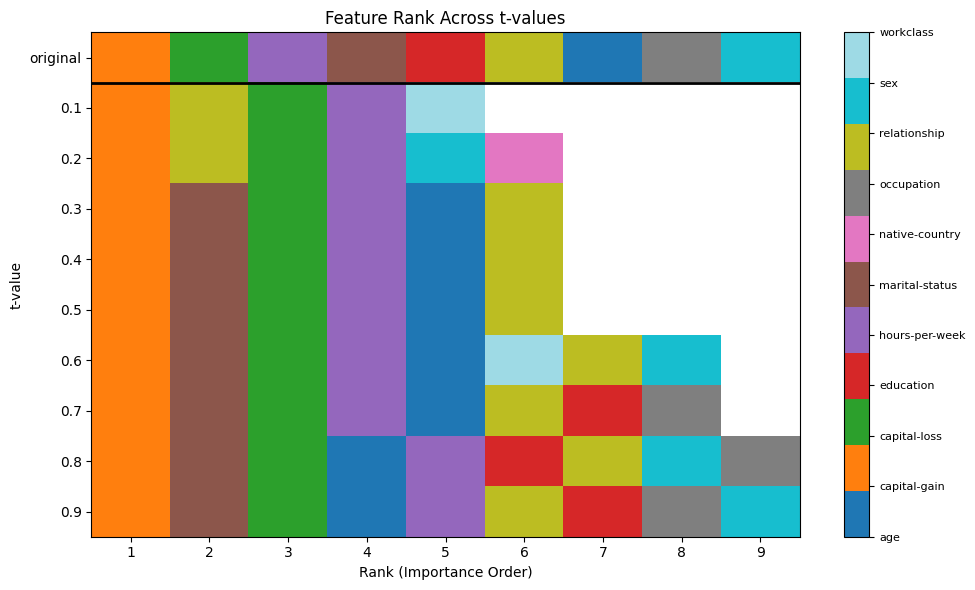

In [42]:
importance_vector = [model_importance]
importance_vector.extend(feature_importance)

feature_names = sorted(list(set(f[0] for run in importance_vector for f in run)))
feature_to_int = {name: i for i, name in enumerate(feature_names)}
num_runs = len(importance_vector)
max_features = max(len(run) for run in importance_vector)
rank_matrix = np.full((num_runs, max_features), np.nan)

for i, run in enumerate(importance_vector):
    for j, (feature_name, _) in enumerate(run):
        rank_matrix[i, j] = feature_to_int[feature_name]

cmap = plt.get_cmap("tab20", len(feature_names))
cmap.set_bad("white")

plt.figure(figsize=(10, 6))
plt.imshow(rank_matrix, aspect="auto", cmap=cmap, interpolation="none")

plt.axhline(0.5, color="black", linewidth=2, linestyle="-")

cbar = plt.colorbar(
    ticks=np.arange(len(feature_names)),
    format=plt.FuncFormatter(lambda val, loc: feature_names[int(val)]),
)
cbar.ax.tick_params(labelsize=8)

plt.title("Feature Rank Across t-values")
plt.xlabel("Rank (Importance Order)")
plt.ylabel("t-value")
plt.xticks(np.arange(max_features), np.arange(1, max_features + 1))
plot_names = [str(round(i, 1)) for i in np.linspace(0.1, 0.9, 9)]
plt.yticks(np.arange(num_runs), ["original"] + plot_names)

plt.tight_layout()
plt.savefig("feature_rank_heatmap.png")

In [17]:
def to_ranking(relations):
    names = (
        data[0].feature_names
    )  # All data have the same mapping, so we can pick an arbitrary AdultPrep object
    return [names.index(feature) for feature, _ in relations]


def add_missing_categories(ref, rnk):
    out = copy(rnk)
    for feat in ref:
        if feat not in rnk:
            out.append(feat)
    return out


def make_compatible(ref, rnk):
    rnk = add_missing_categories(ref, rnk)
    ref = add_missing_categories(rnk, ref)
    return (ref, rnk)

In [38]:
kendaltau = []
m_rnk = to_ranking(model_importance)
for rel in feature_importance:
    rnk = to_ranking(rel)
    m_rnk, rnk = make_compatible(m_rnk, rnk)
    kendaltau.append(stats.kendalltau(m_rnk, rnk))

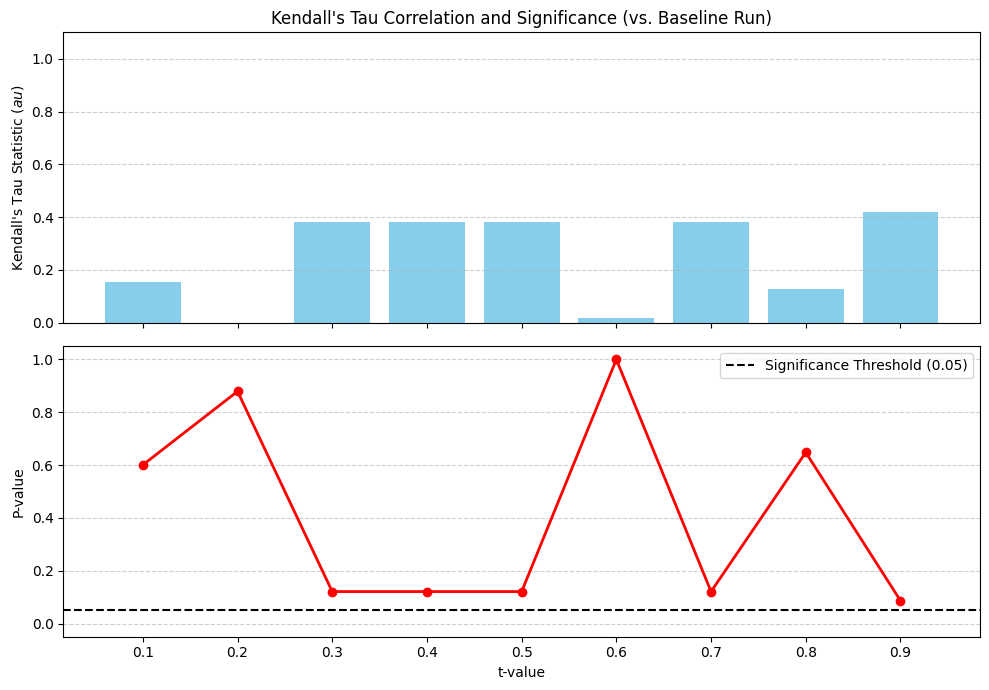

In [39]:
statistics = [n.correlation for n in kendaltau]
pvalues = [n.pvalue for n in kendaltau]
num_runs = len(statistics)
run_indices = np.arange(num_runs)
run_labels = plot_names

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

# --- Plot 1: Kendall's Tau Statistics (Correlation Strength) ---
ax1.bar(run_labels, statistics, color="skyblue")
ax1.set_ylabel("Kendall's Tau Statistic ($\tau$)")
ax1.set_title("Kendall's Tau Correlation and Significance (vs. Baseline Run)")
ax1.grid(axis="y", linestyle="--", alpha=0.6)
ax1.set_ylim(0, 1.1)

# --- Plot 2: P-values (Statistical Significance) ---
ax2.plot(run_labels, pvalues, color="red", marker="o", linestyle="-", linewidth=2)
ax2.set_ylabel("P-value")
ax2.set_xlabel("t-value")
ax2.grid(axis="y", linestyle="--", alpha=0.6)
ax2.set_ylim(-0.05, 1.05)

# Add significance line at p=0.05
ax2.axhline(
    0.05,
    color="black",
    linestyle="--",
    linewidth=1.5,
    label="Significance Threshold (0.05)",
)
ax2.legend()

plt.tight_layout()
plt.savefig("kendall_tau_visualization.png")